# Text Classification with Traditional Machine Learning Methods

## 1
## 2
## 3
## 4

In [1]:
%load_ext watermark
%watermark -v -p numpy,mlxtend,pandas,polars,omegaconf --conda

Python implementation: CPython
Python version       : 3.11.8
IPython version      : 8.22.2

numpy    : 1.26.4
mlxtend  : 0.23.1
pandas   : 2.2.1
polars   : 0.20.18
omegaconf: 2.3.0

conda environment: torch_p11



In [2]:
# Built-in library
from pathlib import Path
import re
import json
from typing import Any, Optional, Union
import logging
import warnings

# Standard imports
import numpy as np
import numpy.typing as npt
from pprint import pprint
import pandas as pd
import polars as pl
from rich.console import Console
from rich.theme import Theme

custom_theme = Theme(
    {
        "info": "#76FF7B",
        "warning": "#FBDDFE",
        "error": "#FF0000",
    }
)
console = Console(theme=custom_theme)

# Visualization
import matplotlib.pyplot as plt


# Pandas settings
pd.options.display.max_rows = 1_000
pd.options.display.max_columns = 1_000
pd.options.display.max_colwidth = 600

warnings.filterwarnings("ignore")


# Black code formatter (Optional)
%load_ext lab_black

# auto reload imports
%load_ext autoreload
%autoreload 2

### WordCloud

- A wordcloud is a visual way to represent text data.
- The bigger a word is in the cloud, the more frequently it appears in the text and this helps you see what the main topics or themes are at a glance.

In [3]:
fp: str = "../../data/spam_data/spam.txt"

with open(fp, "r") as f:
    text: str = f.read()

text

'Dear MR tjones,\t\nYou have noticed lately that your laptop is running slow! This is because I gained access to your machine and I installed a harmful VIRUS!!!\nEven if you change your password my virus CANNOT BE intercepted!\nThe only SOLUTION is to follow my instructions here: http://goo.gl/ihsn9w\nYou have 48 hours before the virus is activated! ...OTHERWISE...GOOD LUCK!!!!\n'

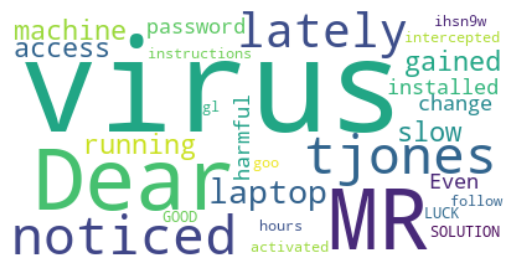

In [4]:
from wordcloud import WordCloud


wc = WordCloud(
    background_color="white", max_words=1000, contour_width=3, contour_color="steelblue"
)

# Generate a word cloud
word_cloud = wc.generate(text)

# Display the generated image:
plt.imshow(word_cloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Label Encode


In [5]:
import string


def tokenize(doc: str | list[str], drop_punct: bool = True) -> list[str]:
    """
    Tokenize the input document and optionally remove punctuation.

    Parameters
    ----------
    doc : str or list of str
        The input document as a string or list of strings.
    drop_punct : bool, optional
        Whether to remove punctuation (default is True).

    Returns
    -------
    list of str
        The tokenized document as a list of strings.
    """
    # Pattern for separating tokens
    pattern: str = r'([,.?_!"()\':]|\s)'

    if isinstance(doc, str):
        tok_doc: list[str] = re.split(pattern=pattern, string=doc.lower())

    if isinstance(doc, list):
        doc = [word.lower() for word in doc]
        tok_doc = re.split(pattern=pattern, string=" ".join(doc))

    # Remove whitespaces and empty strings
    tok_doc = [word for word in tok_doc if word.strip()]

    if drop_punct:
        tok_doc = [word for word in tok_doc if word not in string.punctuation]

    return tok_doc

In [6]:
from sklearn.preprocessing import LabelEncoder


text: str = "It is good to be a good person. I like good and honest people."
tok_text: list[str] = tokenize(doc=text)
print(f"{tok_text = }")

le: LabelEncoder = LabelEncoder()
txt_2_idx: np.ndarray = le.fit_transform(list(set(tok_text)))
print(f"{txt_2_idx = }")
idx_2_txt: np.ndarray = le.inverse_transform(txt_2_idx)
print(f"{idx_2_txt = }")
vocab: dict[str, Any] = {key: val for key, val in zip(idx_2_txt, txt_2_idx)}
console.print(f"{vocab = }")

tok_text = ['it', 'is', 'good', 'to', 'be', 'a', 'good', 'person', 'i', 'like', 'good', 'and', 'honest', 'people']
txt_2_idx = array([ 8,  6, 11,  0,  4,  2, 10,  3,  1,  7,  5,  9])
idx_2_txt = array(['like', 'is', 'to', 'a', 'honest', 'be', 'person', 'good', 'and',
       'it', 'i', 'people'], dtype='<U6')


vocab = {'like': 8, 'is': 6, 'to': 11, 'a': 0, 'honest': 4, 'be': 2, 'person': 10, 'good': 3, 'and': 1, 'it': 7, 
'i': 5, 'people': 9}

### One Hot Encoding

- Another well-known word representation technique is one-hot encoding, which codifies every word
as a vector with zeros and a single one.

In [7]:
from sklearn.preprocessing import OneHotEncoder


ohe: OneHotEncoder = OneHotEncoder(handle_unknown="ignore")
tok_text_arr: np.ndarray = np.array(tok_text).reshape(-1, 1)
ohe_arr: np.ndarray = ohe.fit_transform(tok_text_arr).toarray()

schema: dict[str, Any] = {col: pl.UInt8 for col in tok_text}
df: pl.DataFrame = pl.DataFrame(ohe_arr)
df.columns = sorted(set(tok_text))
df.to_pandas()

,a,and,be,good,honest,i,is,it,like,people,person,to
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
8,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


### Count Vectorizer (Term Frequency / Bag of Words)

- Token count encoding, also known as the Bag-of-Words (BoW) representation, counts the absolute
frequency of each word within a sentence or a document.
The input is represented as a bag of words without taking into account grammar or word order. 

In [8]:
from sklearn.feature_extraction.text import CountVectorizer


vectorizer: CountVectorizer = CountVectorizer()
count_vectors: np.ndarray = vectorizer.fit_transform([text]).toarray()
vocab: np.ndarray = vectorizer.vocabulary_
console.print(f"{text = }")
console.print(f"{vocab = }")
console.print(f"{count_vectors = }")

text = 'It is good to be a good person. I like good and honest people.'

vocab = {'it': 5, 'is': 4, 'good': 2, 'to': 9, 'be': 1, 'person': 8, 'like': 6, 'and': 0, 'honest': 3, 'people': 7}

count_vectors = array([[1, 1, 3, 1, 1, 1, 1, 1, 1, 1]])

#### Add n-grams

In [9]:
vectorizer: CountVectorizer = CountVectorizer(ngram_range=(2, 2))
count_vectors: np.ndarray = vectorizer.fit_transform([text]).toarray()
console.print(f"{text = }")
vocab: np.ndarray = vectorizer.vocabulary_
console.print(f"{vocab = }")
console.print(f"{count_vectors = }")

text = 'It is good to be a good person. I like good and honest people.'

vocab = {'it is': 7, 'is good': 6, 'good to': 4, 'to be': 10, 'be good': 1, 'good person': 3, 'person like': 9, 
'like good': 8, 'good and': 2, 'and honest': 0, 'honest people': 5}

count_vectors = array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

<br>

### [Term Frequency](https://en.wikipedia.org/wiki/Tf%E2%80%93idf)

- Term frequency, tf(t,d), is the relative frequency of term t within document d.
- where $f_{t,d}$ is the number of times term t appears in document d and $\sum_{t' \in d} f_{t',d}$ is the total number of terms in document d.

$$tf(t,d) = \frac{f_{t,d}}{\sum_{t' \in d} f_{t',d}}$$

#### Dampen the Term Frequency

- Reduce weight of common words within documents.
- i.e. Lower importance of frequent terms per document.

$$log_{tf} = 1 + log(freq_{count} + 1)$$

- Here, 1 is added to both the logarithm and the frequency count to avoid taking the log of zero and to dampen the effect of term frequency.

#### Inverse Document Frequency

- The inverse document frequency is a `measure of how much information the word provides`, i.e., how common or rare it is across all documents.
- It is the logarithmically scaled inverse fraction of the documents that contain the word (obtained by dividing the total number of documents by the number of documents containing the term, and then taking the logarithm of that quotient)

$$ n_{t} = |d \in D: t \in d| $$
$$ idf_{(t,D)} = log (\frac{N}{n_{t} + 1}) + 1 $$

- where $N$ is the total number of documents in the corpus, $t \in d$ is the number of terms in a document, $d \in D$ is a document in the corpus $D$ and 1 is added to the denominator to avoid division-by-zero errors.
- $n_{t}$ is the number of documents that contain the term $t$.

- If the term is not in the corpus, this will lead to a division-by-zero.
  - It is therefore common to adjust the numerator and denominator by adding a smoothing term to avoid this.

## TF-IDF

- `BoW` treats all words equally, making common words like "the" important even though they carry little meaning.
- `tf-idf` addresses this by giving more weight to words that are uncommon in the document collection (corpus) but frequent within a specific document.

$$ tfidf = tf * idf $$
<hr>

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer


corpus: list[str] = [
    "We need to meet tomorrow at the cafeteria.",
    "Meet me tomorrow at the cafeteria.",
    "You have inherited millions of dollars.",
    "Millions of dollars just for you.",
]

vectorizer: TfidfVectorizer = TfidfVectorizer()
tfidf = vectorizer.fit_transform(corpus)
tfidf.toarray()

array([[0.31901032, 0.31901032, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.31901032, 0.        ,
        0.40462414, 0.        , 0.31901032, 0.40462414, 0.31901032,
        0.40462414, 0.        ],
       [0.3889911 , 0.3889911 , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.49338588, 0.3889911 , 0.        ,
        0.        , 0.        , 0.3889911 , 0.        , 0.3889911 ,
        0.        , 0.        ],
       [0.        , 0.        , 0.37222485, 0.        , 0.47212003,
        0.47212003, 0.        , 0.        , 0.        , 0.37222485,
        0.        , 0.37222485, 0.        , 0.        , 0.        ,
        0.        , 0.37222485],
       [0.        , 0.        , 0.37222485, 0.47212003, 0.        ,
        0.        , 0.47212003, 0.        , 0.        , 0.37222485,
        0.        , 0.37222485, 0.        , 0.        , 0.        ,
        0.        , 0.37222485]])

### Cosine Similarity

In [11]:
console.print(corpus)

[
    'We need to meet tomorrow at the cafeteria.',
    'Meet me tomorrow at the cafeteria.',
    'You have inherited millions of dollars.',
    'Millions of dollars just for you.'
]

In [12]:
from sklearn.metrics.pairwise import cosine_similarity


tfidf_arr: np.ndarray = tfidf.toarray()

# Calculate the similarity between the 1st two sentences
# cosine_similarity(tfidf_arr[0].reshape(1, -1), tfidf_arr[1].reshape(1, -1))
cosine_similarity([tfidf_arr[0]], [tfidf_arr[1]])

array([[0.62046087]])

In [13]:
# Cosine similarity of the entire array
cosine_similarity(tfidf_arr)

array([[1.        , 0.62046087, 0.        , 0.        ],
       [0.62046087, 1.        , 0.        , 0.        ],
       [0.        , 0.        , 1.        , 0.55420536],
       [0.        , 0.        , 0.55420536, 1.        ]])

## Data Preprocessing

### Tokenization

- `Tokenization` is the process of breaking down text into smaller pieces called tokens.
- These tokens can be individual characters, words, sentences, or even paragraphs, depending on the specific task.

In [17]:
import spacy


# Load the small English Model
nlp = spacy.load("en_core_web_sm")
text: str = "We need to meet tomorrow at the cafeteria."
print(f"{text = }")
doc = nlp(text)

text = 'We need to meet tomorrow at the cafeteria.'


In [18]:
for token in doc:
    print(token.text, token.pos_, token.dep_)

We PRON nsubj
need VERB ROOT
to PART aux
meet VERB xcomp
tomorrow NOUN npadvmod
at ADP prep
the DET det
cafeteria NOUN pobj
. PUNCT punct


In [19]:
# Tokenize the text
[tok.text for tok in doc]

['We', 'need', 'to', 'meet', 'tomorrow', 'at', 'the', 'cafeteria', '.']

In [21]:
# Sentence Tokenizer
corpus: list[str] = [
    "Hey!",
    "We need to meet tomorrow at the cafeteria.",
    "Meet me tomorrow at the cafeteria.",
    "You have inherited millions of dollars.",
    "Millions of dollars just for you.",
]

corpos_str: str = " ".join(corpus)
doc = nlp(corpos_str)

for sent in doc.sents:
    print(sent)

Hey!
We need to meet tomorrow at the cafeteria.
Meet me tomorrow at the cafeteria.
You have inherited millions of dollars.
Millions of dollars just for you.


#### Stopwords

- `Stopwords` are common words that are generally considered to carry little meaning on their own.
- They are frequently filtered out before further analysis because they tend to clutter the data and can even mislead algorithms.
- Different libraries use different lists of stopwords.

In [23]:
from wordcloud import STOPWORDS


spacy_stopwords: set[str] = nlp.Defaults.stop_words
wc_stopwords = STOPWORDS

print(f"spacy stopwords: {len(spacy_stopwords)}")
print(f"wc stopwords: {len(wc_stopwords)}")

spacy stopwords: 326
wc stopwords: 192


### Lemmatization

- `Lemmatization` in NLP is the process of reducing words to their `base` or dictionary form, also known as their `lemma`.
- i.e. converting words with different inflections (like tense or plurality) to a single canonical form.
- Example: Let's consider the word `"running."` Lemmatization would convert it to its base form, `"run."` 
- Lemmatization applies to verbs, nouns, adjectives, and adverbs.

In [27]:
text: str = (
    "He asked him 'why do you want to become great?' "
    "I am the best version of myself."
)

# Lemmatize
doc = nlp(text)
for token in doc:
    print(f"text: {token.text}, lemma: {token.lemma_}")

text: He, lemma: he
text: asked, lemma: ask
text: him, lemma: he
text: ', lemma: '
text: why, lemma: why
text: do, lemma: do
text: you, lemma: you
text: want, lemma: want
text: to, lemma: to
text: become, lemma: become
text: great, lemma: great
text: ?, lemma: ?
text: ', lemma: '
text: I, lemma: I
text: am, lemma: be
text: the, lemma: the
text: best, lemma: good
text: version, lemma: version
text: of, lemma: of
text: myself, lemma: myself
text: ., lemma: .
